In [2]:
# import libraries
from platform import python_version
print(python_version())
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}
import matplotlib as mpl

from scipy.signal import butter, lfilter, freqz

plt.rc('font', **font)

%run ./scripts/util_func.py
%run ./scripts/model_func.py

width  = 2.5
height = width / 1.2

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('axes', labelsize=9)
mpl.rcParams['lines.dashed_pattern'] = [2, 2]
mpl.rcParams['lines.linewidth'] = 1.0

3.8.13


In [3]:
# import data to dataframe
# Data rate is 20 HZ

r = 0.3 # wheel radius (m)
B = 1.296 # wheel base (m)
A = 1.52 - r*2
m = 260
g = 9.8

dataframe = pd.read_csv("./data/doughnut_boreal/doughnut_data.csv", skiprows=[1])

print(dataframe)

       Unnamed: 0             ros_time  joy_switch  icp_index  cmd_left_vel  \
0               1                    0       False          0      0.000000   
1               2  1606767151233303379       False          1      0.000000   
2               3  1606767151233303379       False          1      0.000000   
3               4  1606767151284414274       False          2      0.000000   
4               5  1606767151334713976       False          2      0.000000   
...           ...                  ...         ...        ...           ...   
28610       28611  1606768581634582642       False      14288      3.266667   
28611       28612  1606768581685314785       False      14289      3.266667   
28612       28613  1606768581733615365       False      14289      3.266667   
28613       28614  1606768581786646445       False      14290      3.266667   
28614       28615  1606768581834961966       False      14290      3.266667   

       meas_left_vel  cmd_right_vel  meas_right_vel

In [4]:
# extract values from dataset

# choose which run to analyse
run = dataframe

time = run['ros_time'].to_numpy()
time = (time - time[0]) * 10 ** (-9) # time (s)

# left_w_vel = run['meas_left_vel'].to_numpy() # left wheel velocity (rad)
# right_w_vel = run['meas_right_vel'].to_numpy() # right wheel velocity (rad)

left_w_vel = run['cmd_left_vel'].to_numpy() # left wheel velocity (rad)
right_w_vel = run['cmd_right_vel'].to_numpy() # right wheel velocity (rad)

left_voltage = run['voltage_left'].to_numpy() # left wheel voltage (V)
right_voltage = run['voltage_right'].to_numpy() # right wheel voltage (V)

left_current = run['current_left'].to_numpy() # left wheel current (A)
right_current = run['current_right'].to_numpy() # right wheel current (A)

icp_x = run['icp_pos_x'].to_numpy() # icp x position (m)
icp_y = run['icp_pos_y'].to_numpy() # icp y position (m)

icp_quat_x = run['icp_quat_x'].to_numpy()
icp_quat_y = run['icp_quat_y'].to_numpy()
icp_quat_z = run['icp_quat_z'].to_numpy()
icp_quat_w = run['icp_quat_w'].to_numpy()

n_points = time.shape[0]

icp_roll = np.zeros(n_points)
icp_pitch = np.zeros(n_points)
icp_yaw = np.zeros(n_points)

for i in range(0, n_points):
    icp_roll[i], icp_pitch[i], icp_yaw[i] = quaternion_to_euler(icp_quat_w[i], icp_quat_x[i], icp_quat_y[i], icp_quat_z[i]) # icp orientation (rad)

icp_id_arr = run['icp_index'].to_numpy()    

imu_pitch = run['imu_y'].to_numpy()
imu_roll = run['imu_x'].to_numpy()
imu_yaw = run['imu_z'].to_numpy()

print(np.max(imu_yaw))

2.7725343704223637


In [5]:
# Evaluate velocities in body frame

body_to_world = np.eye(2)

vel_world = np.zeros((2, icp_id_arr[-1]))
vel_body = np.zeros((2, icp_id_arr[-1]))
vel_yaw = np.zeros(icp_id_arr[-1])

wheel_vels = np.zeros((2, icp_id_arr[-1])) # [l_wheel_vel, r_wheel_vel] (rad/s)

icp_id = icp_id_arr[0]

prev_pose_i = 0

for i in range(1, n_points):
    
    if icp_id_arr[i] != icp_id:
        dt = time[i] - time[prev_pose_i]
    
        body_to_world = up_propa_mat(body_to_world, icp_yaw[i])
        world_to_body = np.transpose(body_to_world)
        
        vel_world[0, icp_id] = (icp_x[i] - icp_x[prev_pose_i]) / dt
        vel_world[1, icp_id] = (icp_y[i] - icp_y[prev_pose_i]) / dt
        vel_yaw[icp_id] = imu_yaw[i]
        
        vel_body[:, icp_id] = world_to_body @ vel_world[:, icp_id]
        
        wheel_vels[0, icp_id] = left_w_vel[i]
        wheel_vels[1, icp_id] = right_w_vel[i]
        
        icp_id = icp_id_arr[i]
        prev_pose_i = i
        
vel_yaw = np.reshape(vel_yaw, (vel_yaw.shape[0]))

[-0.00408359 -0.00462379  0.00056431 ... -0.35886309 -0.29090592
 -0.35998115]


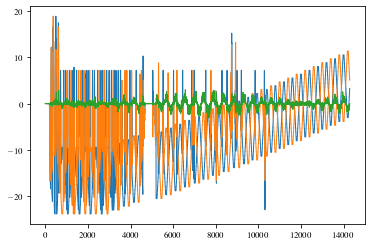

In [6]:
range_start = 0
range_end = 30000

plt.plot(wheel_vels[0, :])
plt.plot(wheel_vels[1, :])

plt.plot(vel_body[1, :])

print(vel_yaw)

In [9]:
# Compute ICR position and centripetal force

n_poses = vel_yaw.shape[0]

icrs = np.zeros((n_poses, 2)) # [x_icr, y_icr]
model_icrs = np.zeros((n_poses, 2))
Fy_icr = np.zeros(n_poses)
Fy_model = np.zeros(n_poses)

for i in range(0, n_poses):
    vx = vel_body[0, i]
    vy = vel_body[1, i]
    vyaw = vel_yaw[i]
    icrs[i, 1] = np.abs(vx / vyaw)
    icrs[i, 0] = np.abs(vy / vyaw)
    Fy_icr[i] = m * np.sqrt(vx**2 + vy**2) / (g * np.sqrt(icrs[i, 0]**2 + icrs[i, 1]**2))\
    
print(icrs)

[[1.30127734e-06 6.72233381e-07]
 [1.33097657e+00 6.11497831e-03]
 [8.02351765e+00 6.13307014e+00]
 ...
 [3.57119514e-02 3.50807202e+00]
 [6.10312671e-03 4.52049763e+00]
 [4.61350463e-02 3.65293050e+00]]


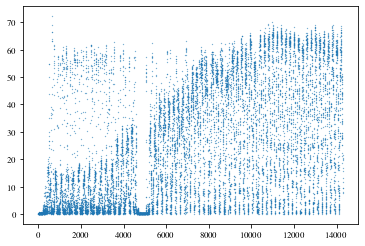

In [10]:
# plt.plot(icrs[:, 0], alpha=0.8)
# plt.plot(icrs[:, 1], alpha=0.8)

plt.plot(Fy_icr, linestyle='None', marker='.', markersize=0.5)

In [82]:
# Compute slip angles from ICRS

def slip_angle_from_vel(vx, vy, vyaw, x, y):
    vx_ci = vx - vyaw * y
    vy_ci = vy + vyaw * x
    
#     if a>0:
#         print('front_vy_c: ', vy_ci)
#     if a<0:
#         print('back_vy_c: ', vy_ci)
#     return wrap2pi(np.arctan2(vy_ci, vx_ci))
    if vy_ci >= 0:
#         if vx_ci >=0:
#             return np.arctan(np.abs(vy_ci / vx_ci))
# #             return 0
        return np.arctan(np.abs(vy_ci / vx_ci))
#         else:
#             return np.arctan(np.abs(vy_ci / vx_ci))
# #             return 0

    else:
#         if vx_ci >=0:
#             return -np.arctan(np.abs(vy_ci / vx_ci))
#             return 0
#         else:
# #             return -np.pi + np.arctan(np.abs(vy_ci / vx_ci))
#             return -np.arctan(np.abs(vy_ci / vx_ci))
#             return 0
        return -np.arctan(np.abs(vy_ci / vx_ci))
        
    return np.arctan(vy_ci / vx_ci)

def slip_angle_from_icr(icr, x, y, angle):
    if (y * icr[1] > 0) and (icr[1] < y):
        return np.arctan((x - icr[0]) / (y - icr[1]))
    else:
        return np.arctan((x - icr[0]) / (icr[1] - y))

slip_angles_icr = np.zeros((n_poses, 4))
slip_angles_vels = np.zeros((n_poses, 4))
wheel_poses = np.array([[A/2, A/2, -A/2, -A/2], 
                       [B/2, -B/2, B/2, -B/2], 
                       [np.pi/2, np.pi/2, -np.pi/2, -np.pi/2]])

slip_angles_icr_model = np.zeros((n_points, 4))

for i in range(0, n_poses):
    for j in range(0, 4):
        slip_angles_icr[i, j] = slip_angle_from_icr(icrs[i], wheel_poses[0, j], wheel_poses[1, j], wheel_poses[2, j])
        slip_angles_vels[i, j] = slip_angle_from_vel(vel_body[0, i], vel_body[1, i], vel_yaw[i] ,wheel_poses[0, j], wheel_poses[1, j])

print(slip_angles_vels)
print(np.arctan(0/200))

[[-0.61732198 -0.61732296  0.61732465  0.61732563]
 [-1.2206202  -1.22665838 -0.92664703 -0.93568565]
 [ 0.99684593  0.89646837  0.94335643  0.83989069]
 ...
 [-0.11871332 -0.17161657  0.10173626  0.14727462]
 [-0.08993826 -0.11978617  0.08759516  0.11667799]
 [-0.09593147 -0.13686754  0.11714159  0.16686859]]
0.0


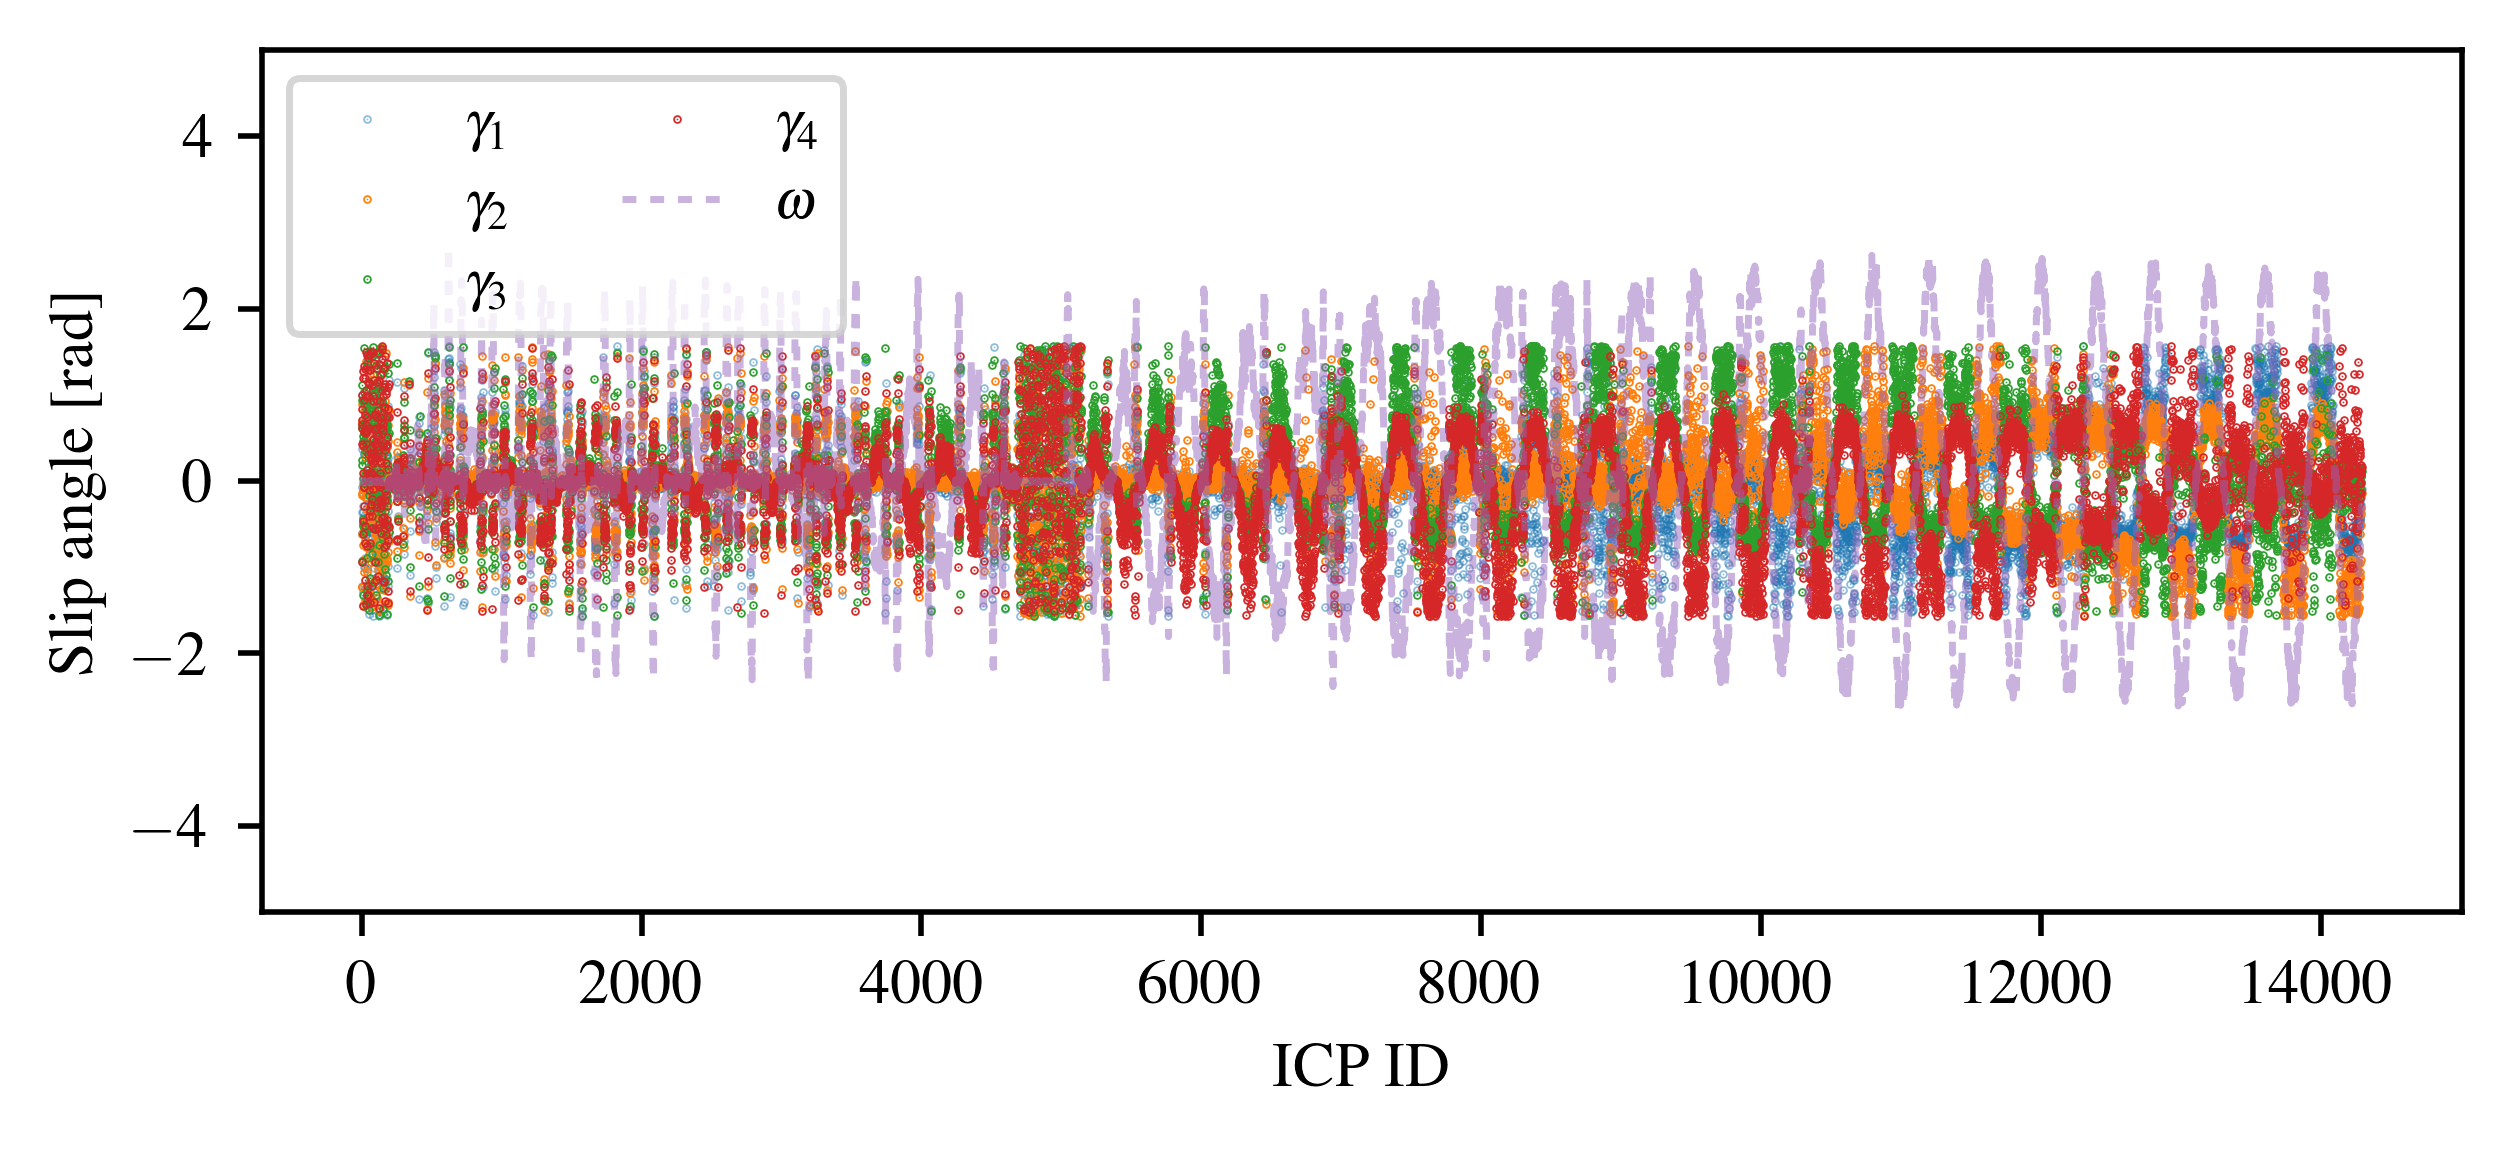

In [86]:
# plot model inputs

fig, ax = plt.subplots(1, 1, dpi=500, gridspec_kw={'hspace': 0.35, 'wspace': 0.23})
fig.set_size_inches(2*width, height+0.1)
fig.subplots_adjust(left=.11, bottom=.18, right=.99, top=.97)
# plt.plot(slip_angles_icr[:, 0], c='C0', label = '$\gamma_1$', linestyle='None', marker='.', markersize=0.5)
# plt.plot(slip_angles_icr[:, 1], c='C1', label = '$\gamma_2$', linestyle='None', marker='.', markersize=0.5)
# plt.plot(slip_angles_icr[:, 2], c='C2', label = '$\gamma_3$', linestyle='None', marker='.', markersize=0.5)
# plt.plot(slip_angles_icr[:, 3], c='C3', label = '$\gamma_4$', linestyle='None', marker='.', markersize=0.5)

plt.plot(slip_angles_vels[:, 0], c='C0', label = '$\gamma_1$', linestyle='None', marker='.', markersize=0.5, alpha=0.5)
plt.plot(slip_angles_vels[:, 1], c='C1', label = '$\gamma_2$', linestyle='None', marker='.', markersize=0.5)
plt.plot(slip_angles_vels[:, 2], c='C2', label = '$\gamma_3$', linestyle='None', marker='.', markersize=0.5)
plt.plot(slip_angles_vels[:, 3], c='C3', label = '$\gamma_4$', linestyle='None', marker='.', markersize=0.5)

plt.plot(vel_yaw, c='C4', label = '$\omega$', linestyle='--', marker='None', alpha=0.5)
# plt.plot(vel_body[0, :], c='C5', label = '$V_x$', linestyle='None', marker='.', markersize=0.5)
# plt.plot(vel_body[1, :], c='C6', label = '$V_y$', linestyle='None', marker='.', markersize=0.5)

# ax.set_title('Contact force inputs for the 0.5 m/s experiment')
# ax.set_xlim(-0.1, 9.1)
ax.set_ylim(-5, 5)
ax.set_xlabel('ICP ID')
ax.set_ylabel('Slip angle [rad]')
ax.legend(loc='upper left', ncol=2)

# plt.annotate('ICR passes wheelbase', xy=(4.4, -1.2),xytext=(1, -1.2) , horizontalalignment="left", arrowprops=dict(arrowstyle='->',lw=1))


In [96]:
# Compute slip angle for each vel and estimate lateral forces through linear model

def piecewise_linear(slip_qty, C):
    return slip_qty * C

def compute_lat_vel(vx, vy, vyaw, a):
    return vy + a * vyaw

C_skid = -32
C_slip_angle = -5

a_arr = np.array([A/2, A/2, -A/2, -A/2])
Fy_slip_angle = np.zeros(n_poses)
Fy_slip_angle_model = np.zeros(n_poses)

for i in range(0, n_poses):

    for j in range(0, 4):
        
#         Fy_slip_angle[i] = Fy_slip_angle[i] + piecewise_linear(slip_angles_icr[i,j], C_slip_angle)
        Fy_slip_angle[i] = Fy_slip_angle[i] + piecewise_linear(slip_angles_icr[i,j], C_slip_angle)
        

print(Fy_slip_angle)

[2.67053801e-05 2.15480563e+01 1.83828072e+01 ... 2.06595058e-01
 2.72563980e-02 2.56055816e-01]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


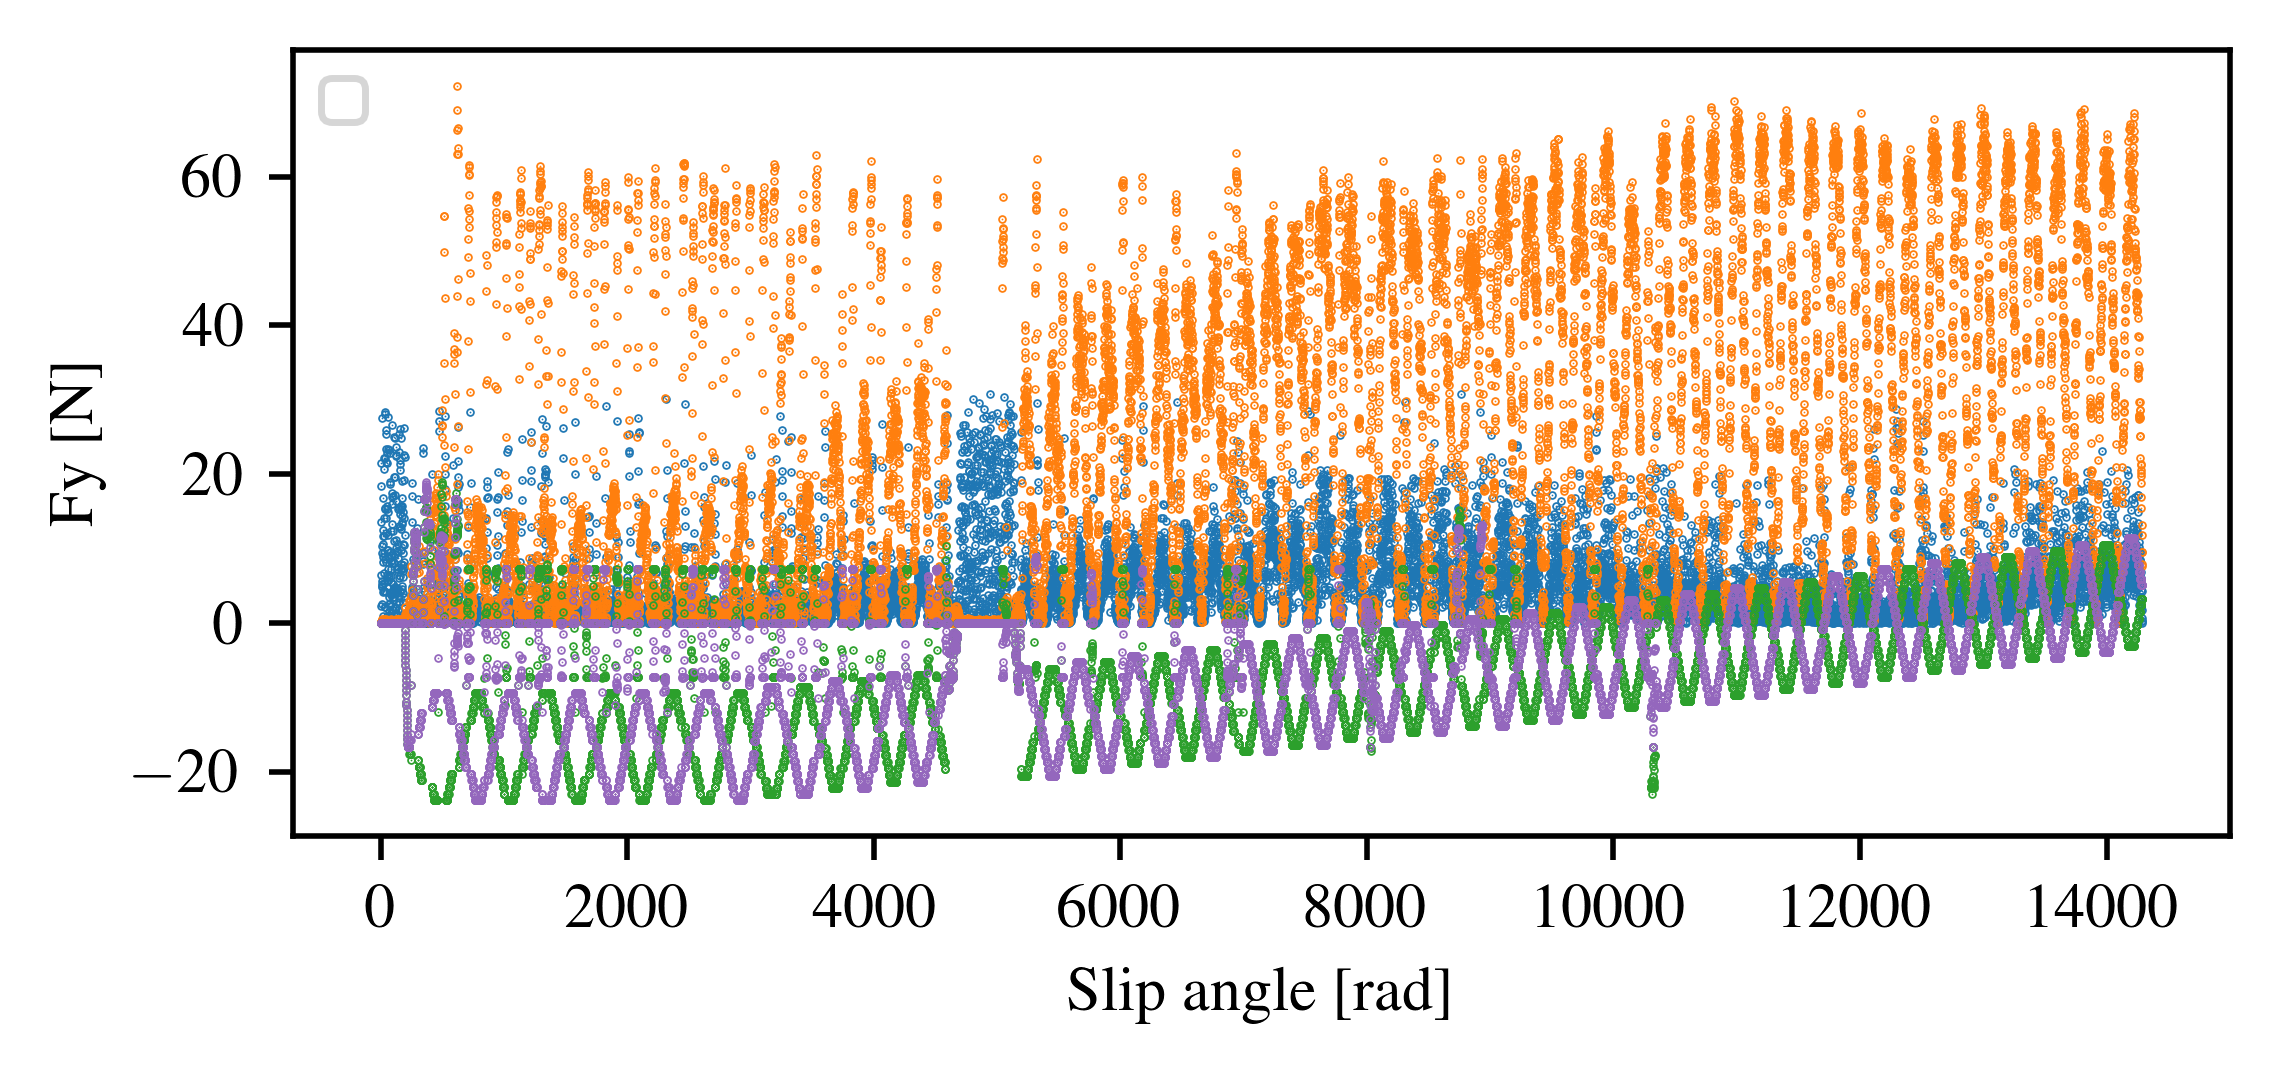

In [102]:
fig, ax = plt.subplots(1, 1, dpi=500, gridspec_kw={'hspace': 0.35, 'wspace': 0.23})
fig.set_size_inches(2*width, height)
# fig.subplots_adjust(left=.11, bottom=.18, right=.99, top=.97)
plt.plot(Fy_slip_angle, linestyle='None', marker='.', markersize=0.5, c='C0')
plt.plot(Fy_icr, linestyle='None', marker='.', markersize=0.5, c='C1')
plt.plot(wheel_vels[0, :], linestyle='None', marker='.', markersize=0.5, c='C2')
plt.plot(wheel_vels[1, :], linestyle='None', marker='.', markersize=0.5, c='C4')


# ax.set_title('Contact force inputs for the 0.5 m/s experiment')
# ax.set_xlim(-0.1, 9.1)
# ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('Slip angle [rad]')
ax.set_ylabel('Fy [N]')
ax.legend(loc='upper left', ncol=2)

# plt.annotate('ICR passes wheelbase', xy=(4.4, -1.2),xytext=(1, -1.2) , horizontalalignment="left", arrowprops=dict(arrowstyle='->',lw=1))